Integrantes :

*Flavio Ruvalcaba Leija,*

*Oscar Nieto Espitia,*

*Jaime Lopez Hernandez,*

*Cristian Espinoza Diaz*

                                    
# Plan de Análisis



### Objetivos de analisis


Se construirá un modelo que prediga con mayor precisión las ventas unitarias de miles de artículos vendidos en diferentes tiendas. Practicaremos nuestras habilidades de aprendizaje automático con un conjunto de datos.

### Preguntas Principales

¿Qué eventos de la vida real afectan las predicciones de ventas como las festividades, fenómenos naturales, etc.?


¿Cómo se relacionan los conjuntos de datos?


¿Las transacciones poseen una relación directa con la clasificación de las tiendas?


¿Cuál es la relación entre las tiendas?


¿Qué tipos de datos tenemos?


¿Cuál es la frecuencia de los datos temporales?


¿Los conjuntos de datos son comparables?


¿Qué modelos de aprendizaje máquina son los más apropiados para este contexto en particular?


¿Cuál va a ser el criterio para manejar las variables categóricas?


¿Qué características serán más influyentes para la predicción?


### Preguntas Secundarias

¿Hay correlación entre las promociones de ciertos productos y un aumento de ventas?


¿Cuál porcentaje de las familias de productos abarcan la mayoría de ventas?


¿Cómo manejar los valores faltantes en los diferentes conjuntos de datos?


¿Hay alguna familia de productos que predomine?


¿Existe correlación entre tiendas similares?


¿Existirá un patrón entre las transacciones y el número de ventas?


# Plan de Datos
Para este contexto en específico, pronostico de ventas en un entorno de tiendas, elegímos seleccionar los siguientes criterios que creemos que podrían ser relevantes.

## Criterios de inclusión:
- Datos de Ventas Históricas: Incluir registros de ventas pasadas para todas las tiendas y productos en el período de tiempo relevante.

- Información de Productos y Tiendas: Incluir detalles relevantes sobre productos (como categorías, marcas y tamaños) y tiendas (ubicaciones, tamaños y características) que puedan influir en las ventas.

- Información Temporal: Incluir datos de fechas que indiquen el día, mes, año, días de la semana y festividades relevantes para capturar patrones estacionales y efectos temporales en las ventas.

- Promociones: Incluir información sobre promociones y descuentos que se hayan aplicado en el pasado y que puedan afectar las ventas.

- Variables Externas: Incluir variables externas pertinentes, como datos climáticos, eventos especiales en la ciudad o información económica que pueda influir en las ventas.

## Criterios de exclusión:
- Datos Irrelevantes: Excluir datos que no aportan información significativa para el pronóstico de ventas, como identificadores únicos sin utilidad predictiva real.

- Outliers Extremos: Identificar outliers mediante un método estadístico como el rango intercuartil (IQR) y excluir valores que caigan por debajo de Q1 - 1.5 * IQR o por encima de Q3 + 1.5 * IQR, donde Q1 es el primer cuartil y Q3 es el tercer cuartil.

- Datos Duplicados: Eliminar registros duplicados o redundantes que tienen exactamente los mismos valores en todas las características.

- Valores Faltantes: Evaluar la cantidad y distribución de valores faltantes. Excluir registros con un alto porcentaje de valores faltantes si no pueden ser imputados de manera razonable.

- Datos Futuros: Excluir datos que representen información futura no disponible en el momento de la predicción, como datos de ventas que ocurrieron después del período de pronóstico deseado.


# EXTRACCION



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from google.colab import drive
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats
from sklearn.model_selection import cross_val_score

In [ ]:
drive.mount("/content/gdrive")
!pwd
%cd "/content/gdrive/Shareddrives/Inteligencia Artificial/inputData"
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/Shareddrives/Inteligencia Artificial/inputData
/content/gdrive/Shareddrives/Inteligencia Artificial/inputData
model_plot.png	StoreSales  submission.csv


## Importamos todos los datos


Conjuntos de datos que se emplearán:

Este conjunto de datos contiene información sobre las ventas de varios productos en diferentes tiendas a lo largo del tiempo. Las columnas incluyen "id" (un identificador único para cada registro), "date" (la fecha de la venta), "store_nbr" (el número de tienda), "family" (el tipo de familia de productos), "sales" (las ventas totales de una familia de productos en una tienda concreta en una fecha determinada) y "onpromotion" (el número total de artículos de una familia de productos que estaban en promoción en una tienda en una fecha determinada).

In [ ]:
train = pd.read_csv("/content/gdrive/Shareddrives/Inteligencia Artificial/inputData/StoreSales/train.csv",
            usecols = ["date","store_nbr","family","sales","onpromotion"],
            dtype = {
                "store_nbr":"category",
                "family":"category",
                "sales":"float32",
                "onpromotion":"uint32"
            },
            parse_dates = ["date"],
            infer_datetime_format=True,
           )

train['date'] = train.date.dt.to_period('D')
train.info()

test = pd.read_csv("/content/gdrive/Shareddrives/Inteligencia Artificial/inputData/StoreSales/test.csv",
           dtype={
               "store_nbr":"category",
               "family":"category",
               "onpromotion":"uint32",
           },
            parse_dates=["date"],
            infer_datetime_format=True,
           )

test["date"] = pd.to_datetime(test['date'])
test = test.set_index(['date','store_nbr', 'family']).sort_values('id')
test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype    
---  ------       -----    
 0   date         period[D]
 1   store_nbr    category 
 2   family       category 
 3   sales        float32  
 4   onpromotion  uint32   
dtypes: category(2), float32(1), period[D](1), uint32(1)
memory usage: 51.5 MB
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 28512 entries, (Timestamp('2017-08-16 00:00:00'), '1', 'AUTOMOTIVE') to (Timestamp('2017-08-31 00:00:00'), '9', 'SEAFOOD')
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   onpromotion  28512 non-null  uint32
dtypes: int64(1), uint32(1)
memory usage: 419.3 KB


Este conjunto de datos contiene información sobre las tiendas en las que se venden los productos. Las columnas incluyen "store_nbr" (el número de tienda), "city" (la ciudad donde se encuentra la tienda), "state" (el estado donde se encuentra la tienda), "type" (el tipo de tienda) y "cluster" (una agrupación de tiendas similares).

In [ ]:
stores = pd.read_csv("/content/gdrive/Shareddrives/Inteligencia Artificial/inputData/StoreSales/stores.csv",
           dtype={
               "store_nbr":"category",
               "city":"category",
               "state":"category",
               "type":"category",
               "cluster":"category",
           },
           )
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


Este conjunto de datos contiene información sobre el número de transacciones en cada tienda en diferentes fechas. Las columnas incluyen "date" (la fecha de las transacciones), "store_nbr" (el número de tienda) y "transactions" (el número de transacciones en esa fecha en esa tienda).

In [ ]:
transactions= pd.read_csv("/content/gdrive/Shareddrives/Inteligencia Artificial/inputData/StoreSales/transactions.csv",
            dtype={
                "store_nbr":"category",
                "transaction":"uint32",
            },
            parse_dates = ["date"],
            infer_datetime_format=True,
           )
transactions["date"] = pd.to_datetime(transactions['date'])
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


 Este conjunto de datos contiene información sobre el precio diario del petróleo. Las columnas incluyen 'date' (la fecha del precio del petróleo) y 'dcoilwtico' (el precio diario del petróleo).

In [ ]:
oil= pd.read_csv("/content/gdrive/Shareddrives/Inteligencia Artificial/inputData/StoreSales/oil.csv",
            dtype={
                "dcoilwtico":"float64",
           },
            parse_dates = ["date"],
            infer_datetime_format=True,
           )
oil['date'] = oil.date.dt.to_period('D')
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype    
---  ------      --------------  -----    
 0   date        1218 non-null   period[D]
 1   dcoilwtico  1175 non-null   float64  
dtypes: float64(1), period[D](1)
memory usage: 19.2 KB


Este conjunto de datos contiene detalles sobre días festivos y eventos. Las columnas incluyen "date" (la fecha de la festividad/evento), "type" (el tipo de festividad/evento), "locale" (la localidad del evento), "locale_name" (el nombre de la localidad), "description" (una descripción de la festividad/evento) y "transferred" (indica si la festividad/evento se trasladó a otra fecha).

In [ ]:
holidays_events = pd.read_csv("/content/gdrive/Shareddrives/Inteligencia Artificial/inputData/StoreSales/holidays_events.csv",
            parse_dates = ["date"],
            infer_datetime_format=True,
           )
holidays_events['date'] = holidays_events.date.dt.to_period('D')
holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


#TRANSFORMACIÓN

## Sales (Ventas)

Una de las primeras ideas que surgio para el análisis del número de ventas fue analizar si existe alguna relación entre las diferentes tiendas y en caso de que si haya evidencia significativa, analizar de qué tipo es.

Es por ello que se procedio a analizar las correlaciones de todas las tiendas entre las mismas para analizar si hay ciertas conglomeraciones o agrupaciones que se asemejen y tengan alguna influencia en la cantidad de ventas dependiendo de las diferentes agrupaciones.

<ipython-input-66-287121fbb9eb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a["ind"] = 1
<ipython-input-66-287121fbb9eb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a["ind"] = a.groupby("store_nbr").ind.cumsum().values


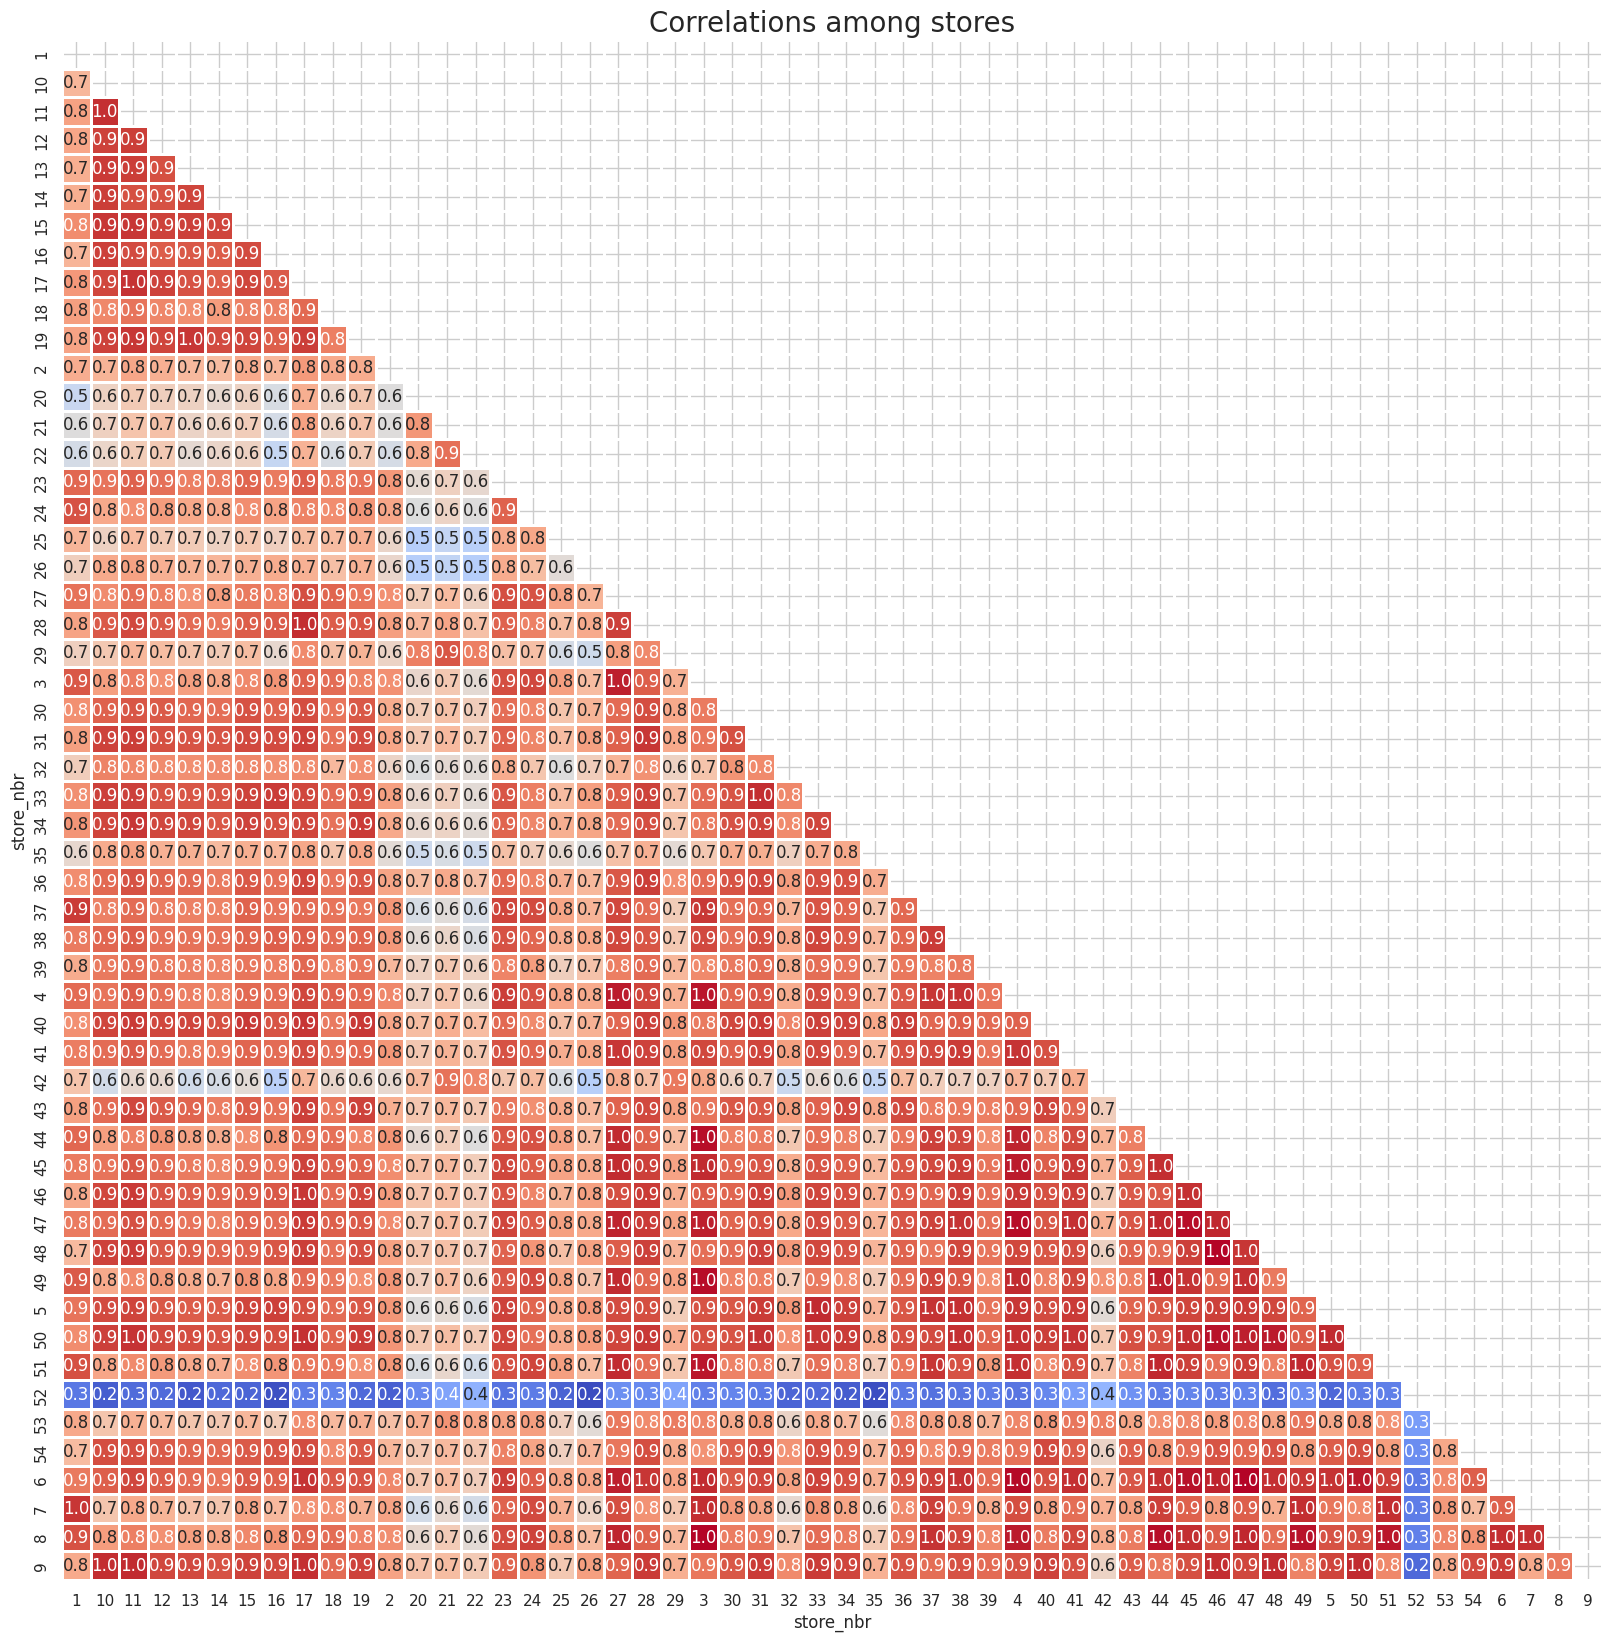

In [ ]:
a = train[["store_nbr", "sales"]]
a["ind"] = 1
a["ind"] = a.groupby("store_nbr").ind.cumsum().values
a = pd.pivot(a, index = "ind", columns = "store_nbr", values = "sales").corr()
mask = np.triu(a.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(a,
        annot=True,
        fmt='.1f',
        cmap='coolwarm',
        square=True,
        mask=mask,
        linewidths=1,
        cbar=False)
plt.title("Correlations among stores",fontsize = 20)
plt.show()

Otro aspecto importante es visualizar los promedios de las ventas de los productos para identificar los patrones a través del tiempo.
De esta manera, podemos observar cuales son los productos más relevantes y de cuáles encontramos el mayor volumen de ventas.

In [ ]:
average_sales_per_family = train.groupby('family')['sales'].mean()
sorted_average_sales_per_family = average_sales_per_family.sort_values(ascending=False)

print(sorted_average_sales_per_family)

family
GROCERY I                     3776.971924
BEVERAGES                     2385.792969
PRODUCE                       1349.352173
CLEANING                      1072.416748
DAIRY                          709.154907
BREAD/BAKERY                   463.336243
POULTRY                        350.532288
MEATS                          341.849976
PERSONAL CARE                  270.432526
DELI                           265.135071
HOME CARE                      176.198029
EGGS                           171.420517
FROZEN FOODS                   154.766953
PREPARED FOODS                  96.770203
LIQUOR,WINE,BEER                85.187828
SEAFOOD                         22.163191
GROCERY II                      21.584047
HOME AND KITCHEN I              20.470343
HOME AND KITCHEN II             16.722420
CELEBRATION                      8.370469
LINGERIE                         7.182128
LADIESWEAR                       7.160629
PLAYERS AND ELECTRONICS          6.186857
AUTOMOTIVE                 

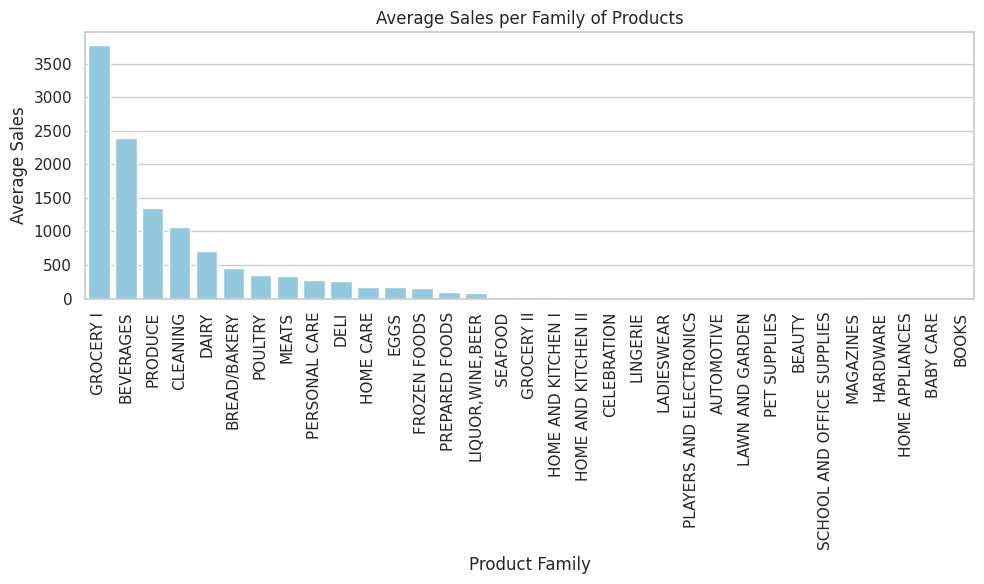

In [ ]:
sns.set(style="whitegrid")
sns.set_palette("pastel")

plt.figure(figsize=(10, 6))
sorted_order = sorted_average_sales_per_family.sort_values(ascending=False).index
sns.barplot(x=sorted_average_sales_per_family.index, y=sorted_average_sales_per_family.values, color='skyblue', order=sorted_order)
plt.title('Average Sales per Family of Products')
plt.xlabel('Product Family')
plt.ylabel('Average Sales')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Gracias a la gráfica anterior se puede observar que de las 33 familias de productos, alrededor de 15 familias son las que tienen la mayoría de las ventas. Con base en esto, sería importante ver si estas familias tienen el mayor volumen de ventas porque esas familias hayan tenido el mayor número de promociones por ejemplo.

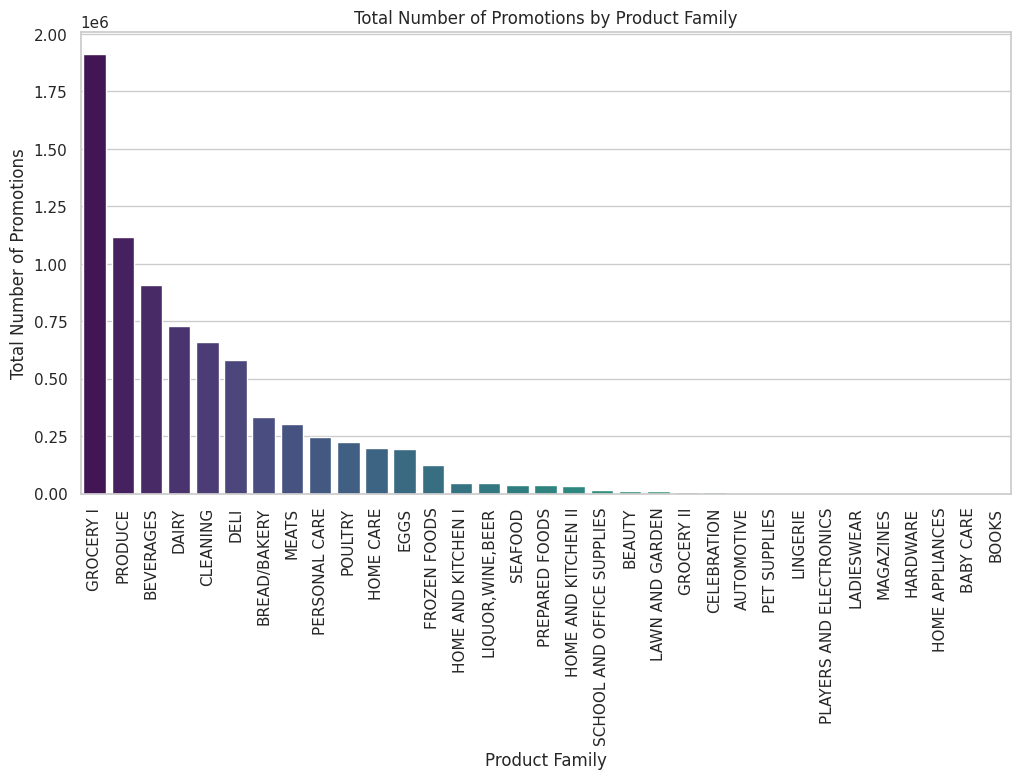

In [ ]:
promotions_by_family = train.groupby('family')['onpromotion'].sum()

promotions_by_family = promotions_by_family.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=promotions_by_family.index, y=promotions_by_family.values, palette='viridis',order=promotions_by_family.index)
plt.title('Total Number of Promotions by Product Family')
plt.xlabel('Product Family')
plt.ylabel('Total Number of Promotions')
plt.xticks(rotation=90)
plt.show()

Como se puede observar, si hay una relación bastante fuerte entre las familias que tienen el mayor número de ventas con las familias que tienen el mayor número de promociones. Aunque esta relación no es 1 a 1. Es decir que no es la única variable que influye en el # de ventas. Es por ello, que ahora analizaremos si las festividades son una variable de peso en cuanto a su influencia al número de ventas por familia de productos.

Top 5 families for Additional are:
GROCERY I with sales of 10670940.0
BEVERAGES with sales of 6183568.0
PRODUCE with sales of 3931572.75
CLEANING with sales of 2701358.0
DAIRY with sales of 1854514.0
Top 5 families for Bridge are:
GROCERY I with sales of 748964.125
BEVERAGES with sales of 494920.0
CLEANING with sales of 231479.0
PRODUCE with sales of 224386.484375
DAIRY with sales of 133470.0
Top 5 families for Event are:
GROCERY I with sales of 13684741.0
BEVERAGES with sales of 9077222.0
PRODUCE with sales of 5427187.0
CLEANING with sales of 3422722.0
DAIRY with sales of 2481825.0
Top 5 families for Holiday are:
GROCERY I with sales of 33851648.0
BEVERAGES with sales of 20922944.0
PRODUCE with sales of 11416557.0
CLEANING with sales of 9410499.0
DAIRY with sales of 6229246.0


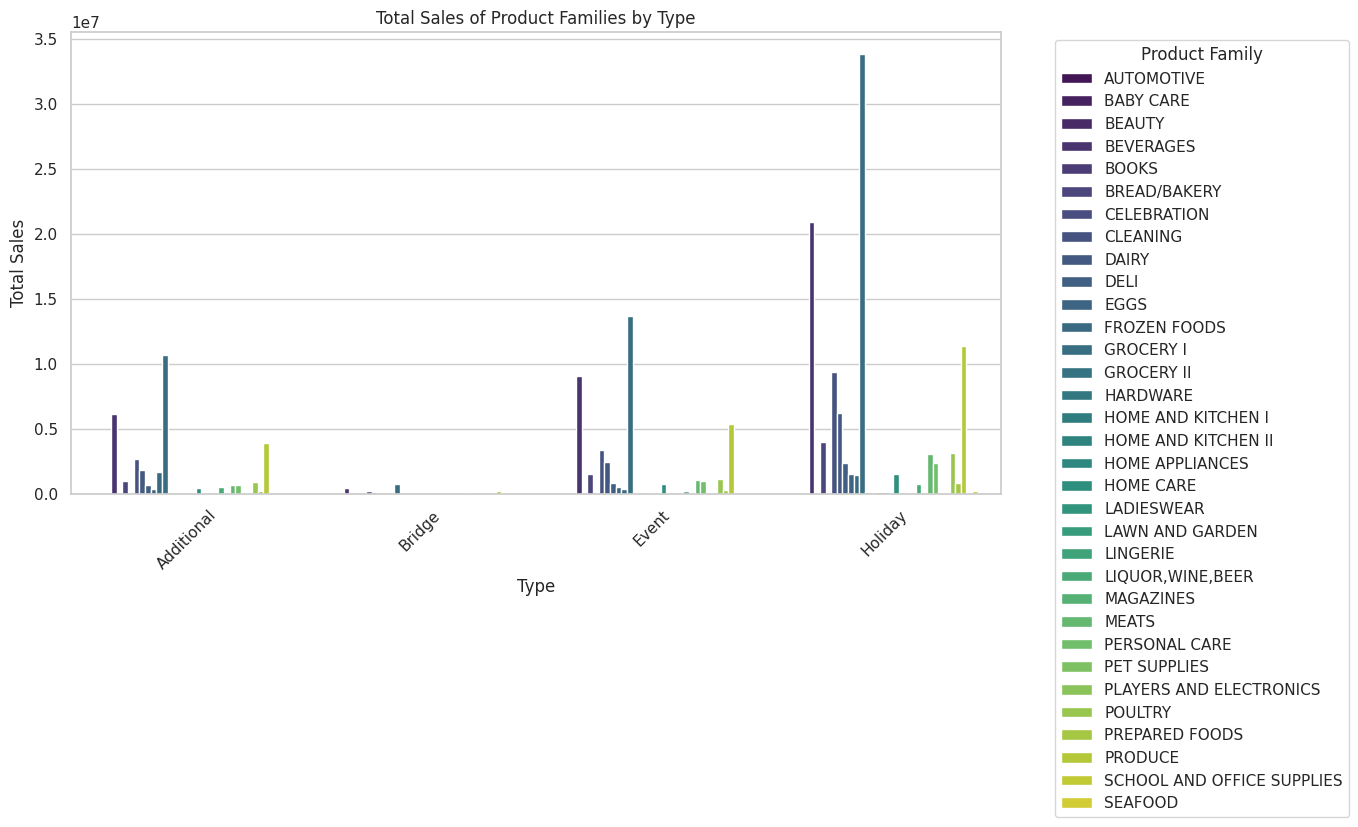

In [ ]:
holidays_events = holidays_events[holidays_events['transferred'] != True]

merged_df = pd.merge(holidays_events, train, on='date', how='inner', suffixes=('_holiday', '_train'))

merged_df = merged_df[merged_df['type'] != 'Transfer']

merged_df = merged_df[merged_df['type'] != 'Work Day']

sales_by_type_and_family = merged_df.groupby(['type', 'family'])['sales'].sum().reset_index()

top_families_by_type = sales_by_type_and_family.groupby('type').apply(lambda x: x.nlargest(5, 'sales')).reset_index(drop=True)

plt.figure(figsize=(12, 6))
sns.barplot(x='type', y='sales', hue='family', data=sales_by_type_and_family, palette='viridis')
plt.title('Total Sales of Product Families by Type')
plt.xlabel('Type')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.legend(title='Product Family', title_fontsize='12', bbox_to_anchor=(1.05, 1), loc='upper left')

for type_name, group in top_families_by_type.groupby('type'):
    print(f"Top 5 families for {type_name} are:")
    for index, row in group.iterrows():
        print(f"{row['family']} with sales of {row['sales']}")

plt.show()

Segun el tipo de festividad, se identifican las mayores ventas por familia de productos con el fin de identificar cual familia de producto es la mas buscada en tiempos de una festividad especifica.

In [ ]:
def grouped(df, key, freq, col):
    df_grouped = df.groupby([pd.Grouper(key=key, freq=freq)]).agg(mean = (col, 'mean'))
    df_grouped = df_grouped.reset_index()
    return df_grouped

In [ ]:
df_grouped_trans_w = grouped(transactions, 'date', 'W', 'transactions')
df_grouped_trans_w

,date,mean
0,2013-01-06,1883.203463
1,2013-01-13,1641.090062
2,2013-01-20,1639.024845
3,2013-01-27,1609.816770
4,2013-02-03,1685.263975
...,...,...
237,2017-07-23,1623.208995
238,2017-07-30,1619.653439
239,2017-08-06,1713.743386
240,2017-08-13,1599.156085


In [ ]:
def add_time(df, key, freq, col):
    df_grouped = grouped(df, key, freq, col)
    df_grouped['time'] = np.arange(len(df_grouped.index))
    column_time = df_grouped.pop('time')
    df_grouped.insert(1, 'time', column_time)
    return df_grouped

In [ ]:
train.head()

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


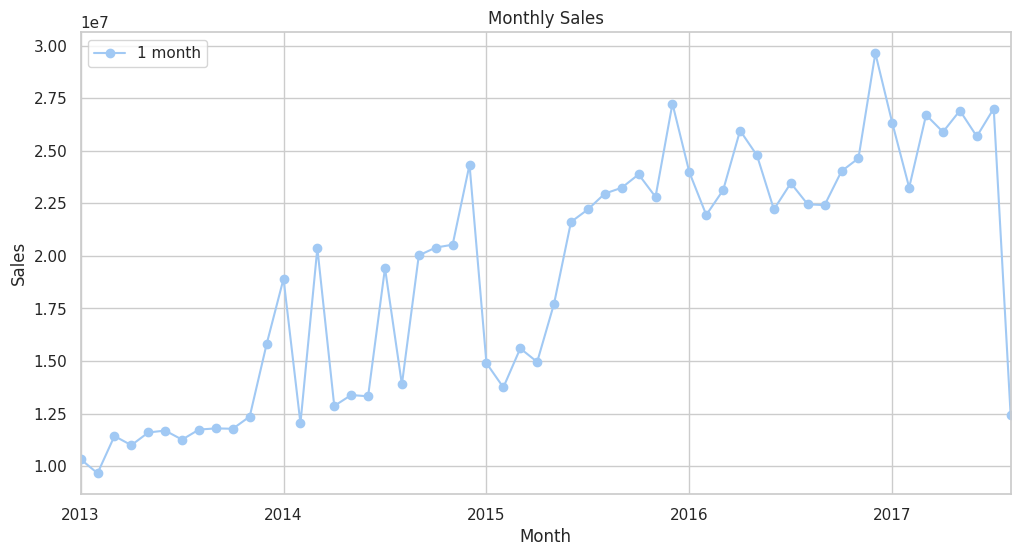

In [ ]:
train_temp = train
train_temp['date'] = train_temp['date'].dt.to_timestamp()

monthly_sales = train_temp.groupby(train_temp['date'].dt.to_period("M"))['sales'].sum()

plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='line', marker='o')
plt.title('Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid(True)
plt.legend(['1 month'], loc='upper left')
plt.show()


En la gráfica anterior podemos analizar la tendencia del número de ventas por mes dentro del rango de 2013-2017. Algunas cosas a denotar es que exceptuando el 2013, el mayor número de ventas es en el mes 12 (Diciembre) y en Enero es cuando el número de ventas se reduce esta cifra significativamente.

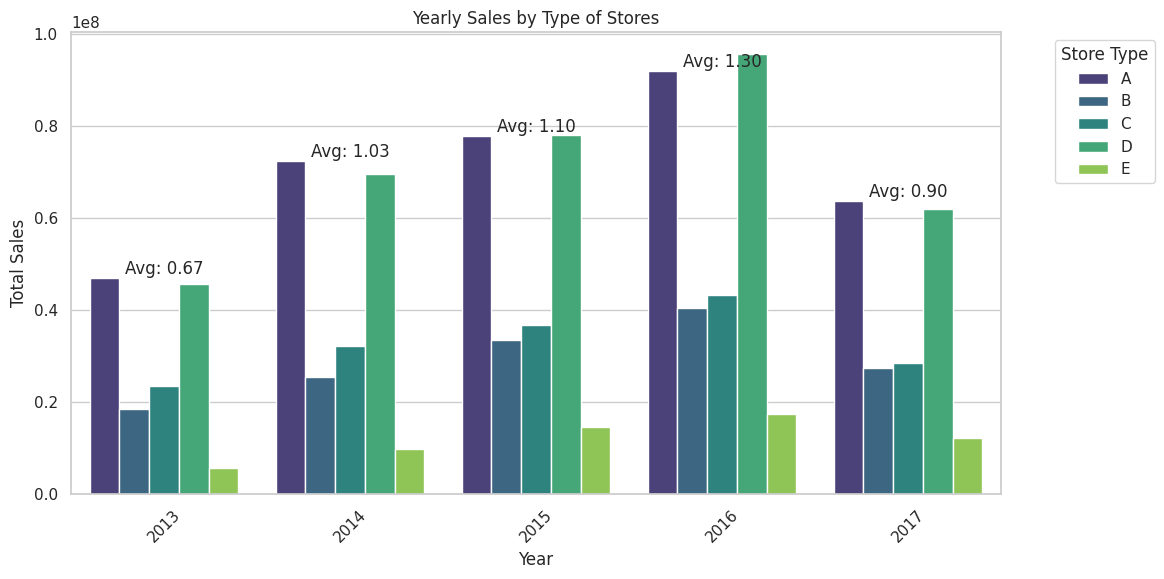

In [ ]:
merged_df = pd.merge(train, stores, on='store_nbr', how='inner')

merged_df['date'] = pd.to_datetime(merged_df['date'])

merged_df['year'] = merged_df['date'].dt.year

yearly_sales_by_type_stores = merged_df.groupby(['type', 'year'])['sales'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='sales', hue='type', data=yearly_sales_by_type_stores, palette='viridis')
plt.title('Yearly Sales by Type of Stores')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.legend(title='Store Type', title_fontsize='12', bbox_to_anchor=(1.05, 1), loc='upper left')

for index, row in yearly_sales_by_type_stores.iterrows():
    plt.annotate(f"Avg: {row['sales'] / yearly_sales_by_type_stores[yearly_sales_by_type_stores['type'] == row['type']]['sales'].mean():.2f}",
                 xy=(index, row['sales']), ha='center', va='bottom')

plt.show()


Sales Moving Average

In [ ]:
def grouped(df, key, freq, col):
    grouped_df = df.groupby([pd.Grouper(key=key, freq=freq)])[col].mean().reset_index()
    return grouped_df

def plot_moving_average(df, key, freq, col, window, min_periods, ax, title):
    df_grouped = grouped(df, key, freq, col)
    moving_average = df_grouped[col].rolling(window=window, center=True, min_periods=min_periods).mean()
    ax = df_grouped[col].plot(color='0.75', linestyle='dashdot', ax=ax)
    ax = moving_average.plot(linewidth=3, color='b', ax=ax)
    ax.set_title(title, fontsize=18)

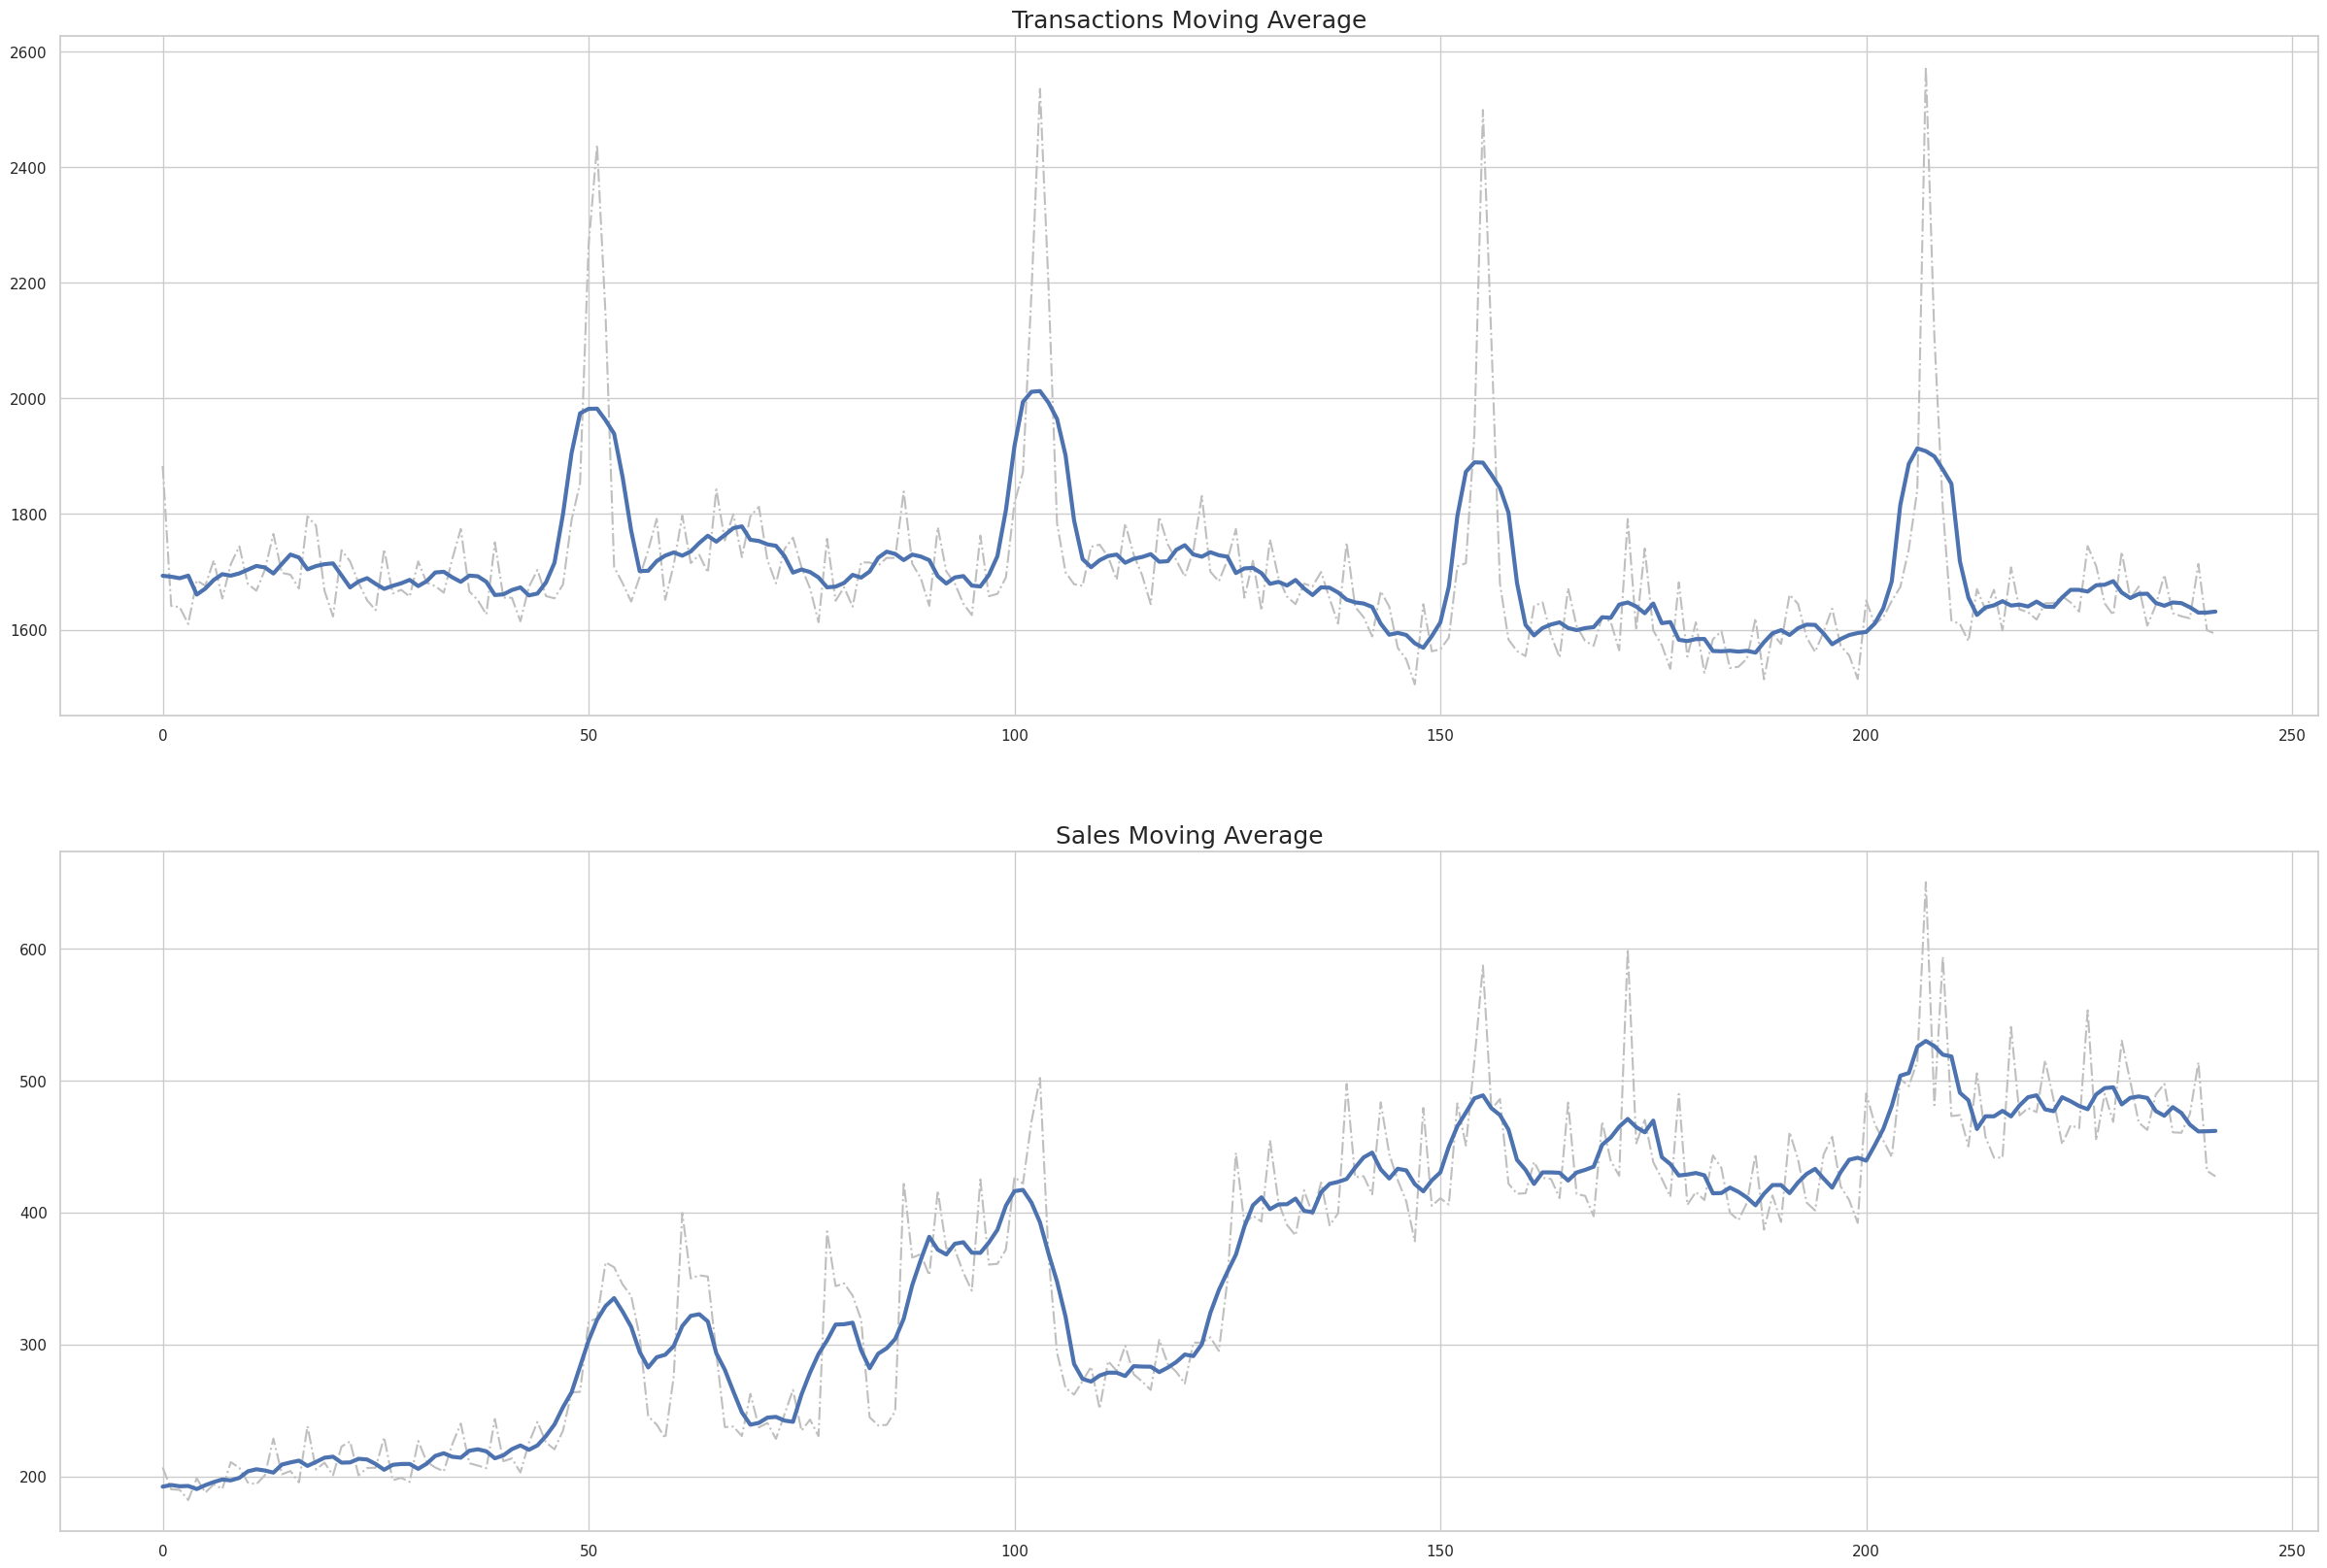

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(30,20))
plot_moving_average(transactions, 'date', 'W', 'transactions', 7, 4, axes[0], 'Transactions Moving Average')
plot_moving_average(train, 'date', 'W', 'sales', 7, 4, axes[1], 'Sales Moving Average')
plt.show()

En la anterior grafica identificamos la tendencia de un cambio persistente y de largo plazo donde podemos ver los gráficos de promedio móvil para transacciones y ventas, coloreados en verde.

En una serie temporal de ventas de productos, una tendencia creciente podría ser el efecto de una expansión del mercado a medida que más personas conocen el producto año tras año.


## Transactions (Transacciones)

In [ ]:
traintemp = train.groupby(['date', 'store_nbr']).sales.mean().reset_index()


In [ ]:
df_aux_merge = pd.merge(traintemp, transactions, how = 'left')


<ipython-input-81-ab10caeea5fe>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data=df_aux_merge.corr(), vmin=-1, vmax=1, cmap = 'RdBu', annot=True, square = True)


<Axes: >

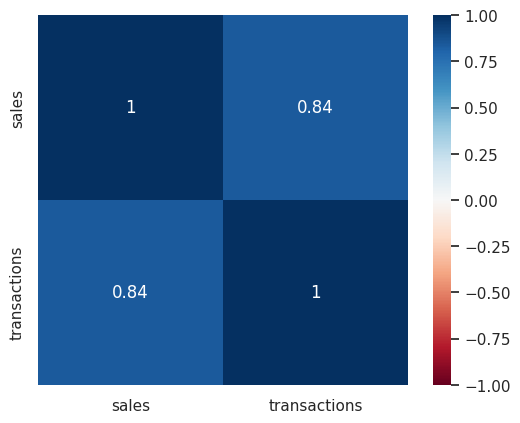

In [ ]:
sns.heatmap(data=df_aux_merge.corr(), vmin=-1, vmax=1, cmap = 'RdBu', annot=True, square = True)


La anterior grafica nos ayuda a visualizar la correlacion entre las ventas y transacciones ya que entre mas cercano esten a uno los valores, implica que hay una correlacion fuerte positiva.

##Oil (Petróleo)

El primer paso crucial que necesitamos examinar es el precio del petróleo, ya que Ecuador, como nación, se encuentra altamente dependiente de este recurso, y su estabilidad económica está en riesgo ante las fluctuaciones en los costos petroleros.

A continuación graficaremos los precios del pétroleo del dataset "oil" para tener un panórama general de los precios.

El método usado para rellenar la información vacía fue bfill.

Este método rellena los valores faltantes con el valor que se encuentra inmediatamente después en la columna. Es decir, utiliza el valor de la siguiente fila para llenar el valor faltante en la fila actual.

Establecemos la columna "date" como indíce para asegurarnos que las fechas se utilicen como etiquetas en el eje X.

Finalmente, graficamos los precios del petróleo.



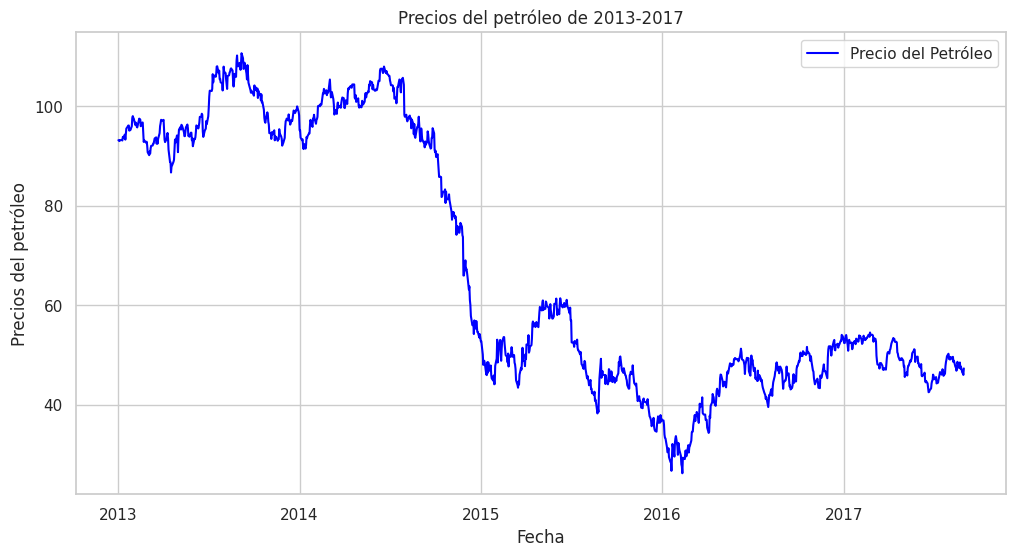

In [ ]:
oil_temp = oil
oil_temp["dcoilwtico"] = oil_temp["dcoilwtico"].fillna(method='bfill',axis=0)
oil_temp['date'] = oil_temp['date'].dt.to_timestamp()
oil_temp = oil_temp.sort_values(by='date')

oil_temp.set_index('date', inplace=True)


plt.figure(figsize=(12, 6))
plt.plot(oil_temp.index, oil['dcoilwtico'], label='Precio del Petróleo', color='blue')
plt.ylabel("Precios del petróleo")
plt.xlabel("Fecha")
plt.title("Precios del petróleo de 2013-2017")
plt.legend()
plt.grid(True)

plt.show()

Posteriormente, realizamos scatter plots sobre los precios de petróleo con las ventas de producto. Con el objetivo de visualizar como es que los precios de petróleo se correlacionan con las ventas para identificar tendencias o patrones.

Debido a esto, uniremos el dataset de oil con train en una variable temporal.

In [ ]:
train2 = pd.merge(train,oil,on='date',how='left')


In [ ]:
train2

,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,2013-01-01,1,AUTOMOTIVE,0.000000,0,93.14
1,2013-01-01,1,BABY CARE,0.000000,0,93.14
2,2013-01-01,1,BEAUTY,0.000000,0,93.14
3,2013-01-01,1,BEVERAGES,0.000000,0,93.14
4,2013-01-01,1,BOOKS,0.000000,0,93.14
...,...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.132996,0,47.57
3000884,2017-08-15,9,PREPARED FOODS,154.552994,1,47.57
3000885,2017-08-15,9,PRODUCE,2419.729004,148,47.57
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000000,8,47.57


Calculamos e imprimimos la correlacion coeficiente entre el precio del petroleo y sus respectivas ventas (Pearson's correlation)


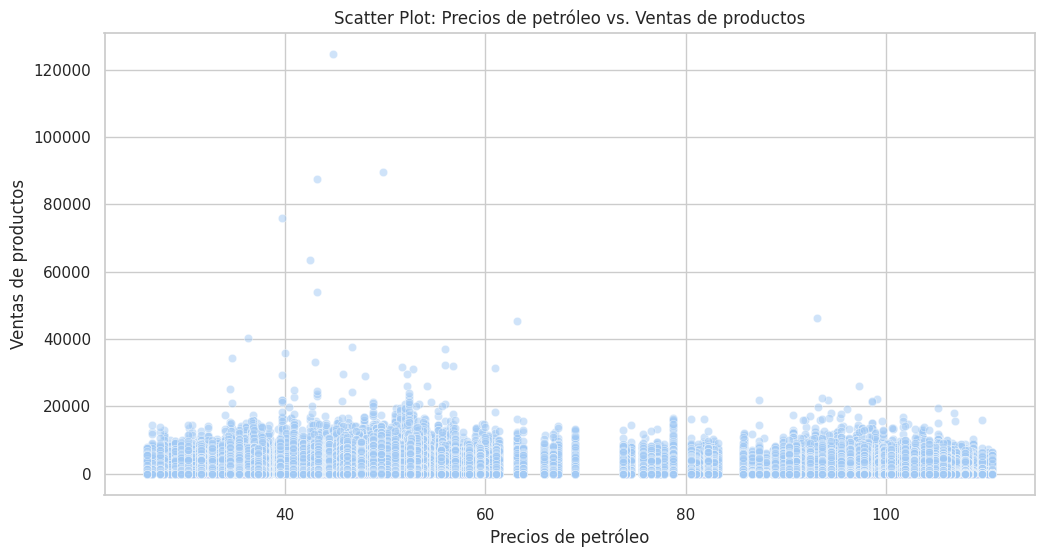

Correlación entre los Precios de petróleo y Ventas: -0.07888528157124691


In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=train2, x='dcoilwtico', y='sales', alpha=0.5)
plt.xlabel('Precios de petróleo')
plt.ylabel('Ventas de productos')
plt.title('Scatter Plot: Precios de petróleo vs. Ventas de productos')
plt.show()

correlation = train2['dcoilwtico'].corr(train2['sales'])
print("Correlación entre los Precios de petróleo y Ventas:", correlation)

* Coeficiente de Correlación y Ventas:

Nuestra observación revela un coeficiente de correlación mínimo y negativo entre el precio del petróleo y las ventas. En otras palabras una relación débil y negativa entre estas dos variables.

* Relación Débil:

Esto se traduce en una relación poco influyente entre los precios del petróleo y las ventas. En promedio, cuando los precios del petróleo suben, las ventas disminuyen ligeramente, y cuando los precios del petróleo disminuyen, las ventas aumentan en una medida igualmente modesta.

* Múltiples Factores a considerar:

La debilidad de esta relación sugiere que otros factores están ejerciendo una influencia significativa en las ventas. Es esencial considerar estos factores adicionales para comprender completamente los impulsores de las ventas.

## Holidays (Festividades)

Un aspecto igualmente importante a tener en cuenta en nuestra análisis de datos es el conjunto de datos 'holiday_events'.

Esto se debe a que durante festividades como la Navidad, la tendencia general es que las personas tienden a aumentar su consumo de una variedad de productos

In [ ]:
holidays_temp = holidays_events
holidays_temp['date'] = holidays_temp['date'].dt.to_timestamp()
holidays_temp.set_index('date', inplace=True)
holidays_temp.sort_index(inplace=True)
train2.set_index('date', inplace=True)
train2 = pd.merge(train2,holidays_temp,on='date',how='left')

In [ ]:
train2

,store_nbr,family,sales,onpromotion,dcoilwtico,type,locale,locale_name,description,transferred
date,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.000000,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,1,BABY CARE,0.000000,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,1,BEAUTY,0.000000,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,1,BEVERAGES,0.000000,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,1,BOOKS,0.000000,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False
...,...,...,...,...,...,...,...,...,...,...
2017-08-15,9,POULTRY,438.132996,0,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
2017-08-15,9,PREPARED FOODS,154.552994,1,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False
2017-08-15,9,PRODUCE,2419.729004,148,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False


In [ ]:
categorias_unicas = train2['type'].unique()
print("Types:", categorias_unicas)

Types: ['Holiday' nan 'Work Day' 'Additional' 'Event' 'Transfer' 'Bridge']


Filtramos la data para la venta en festividades y no festividades.

Creamos histogramas para comparar las ventas.

Calculamos e imprimimos un resumen para las ventas





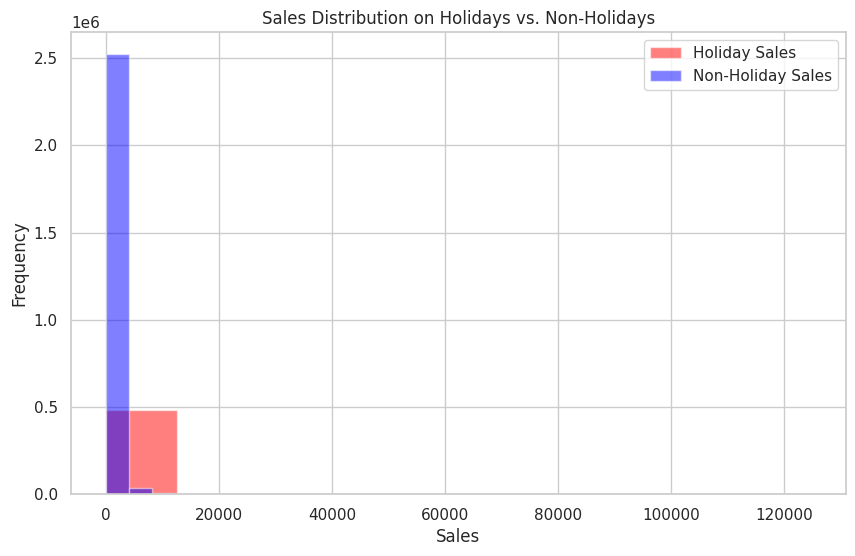

Holiday Sales Statistics:
 count    486486.000000
mean        396.578186
std        1262.252075
min           0.000000
25%           0.000000
50%          12.000000
75%         216.000000
max      124717.000000
Name: sales, dtype: float64

Non-Holiday Sales Statistics:
 count    2.567862e+06
mean     3.519056e+02
std      1.075267e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.930000e+02
max      4.035146e+04
Name: sales, dtype: float64


In [ ]:
holiday_sales = train2[train2['type'].notna()]

non_holiday_sales = train2[train2['type'].isna()]

plt.figure(figsize=(10, 6))
plt.hist(holiday_sales['sales'], bins=10, alpha=0.5, color='red', label='Holiday Sales')
plt.hist(non_holiday_sales['sales'], bins=10, alpha=0.5, color='blue', label='Non-Holiday Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Sales Distribution on Holidays vs. Non-Holidays')
plt.legend()
plt.show()

holiday_sales_stats = holiday_sales['sales'].describe()
non_holiday_sales_stats = non_holiday_sales['sales'].describe()

print("Holiday Sales Statistics:\n", holiday_sales_stats)
print("\nNon-Holiday Sales Statistics:\n", non_holiday_sales_stats)

Agrupamos la data por el tipo de festividad y el promedio de ventas de cada uno.

Creamos una grafica de barras para comparar esas mismas ventas




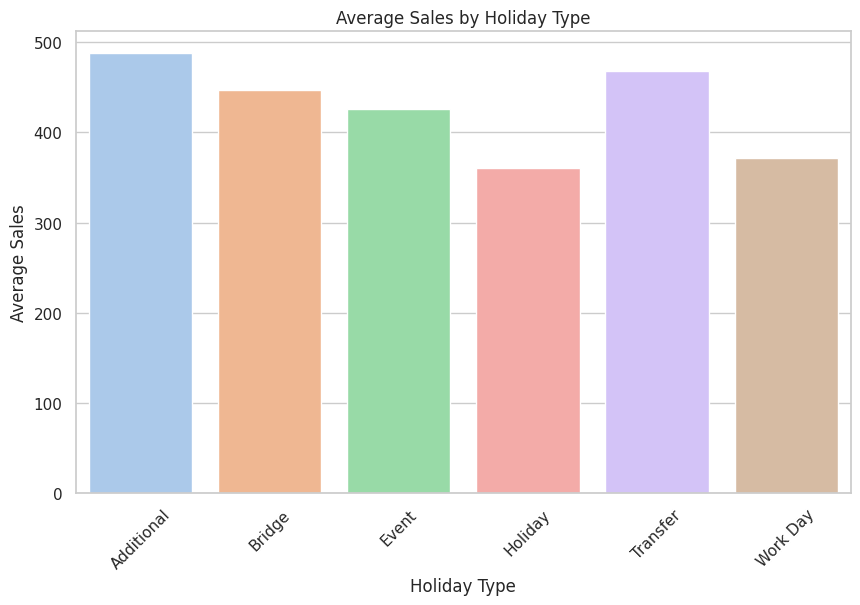

In [ ]:
holiday_type_sales = train2.groupby('type')['sales'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=holiday_type_sales, x='type', y='sales')
plt.xlabel('Holiday Type')
plt.ylabel('Average Sales')
plt.title('Average Sales by Holiday Type')
plt.xticks(rotation=45)
plt.show()

 Creamos un box plot para visualizar la distribucion de ventas por el tipo de festividad


In [ ]:
train2 = pd.merge(train2,stores,on='store_nbr',how='left')
train2 = train2.rename(columns={"type_x":"holiday_type","type_y":"store_type"})

In [ ]:
train2.head()

,store_nbr,family,sales,onpromotion,dcoilwtico,holiday_type,locale,locale_name,description,transferred,city,state,store_type,cluster
0,1,AUTOMOTIVE,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
1,1,BABY CARE,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
2,1,BEAUTY,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
3,1,BEVERAGES,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
4,1,BOOKS,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13


Agrupamos la data por el tipo de tienda y festividad y calculamos el promedio de ventas por cada combinacion.

Creamos una grafica de barras para visualizar las ventas segun el tipo de tienda y festividades.



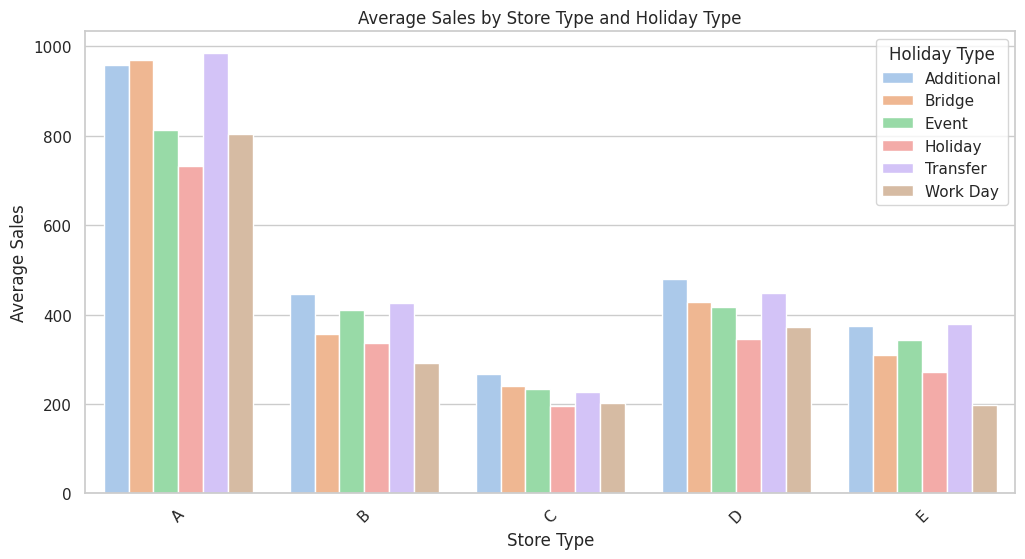

In [ ]:

store_holiday_sales = train2.groupby(['store_type', 'holiday_type'])['sales'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=store_holiday_sales, x='store_type', y='sales', hue='holiday_type')
plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.title('Average Sales by Store Type and Holiday Type')
plt.xticks(rotation=45)
plt.legend(title='Holiday Type')
plt.show()

Decídimos analizar la distribución de las categorías de holidays_events. Lo que podemos asumir de esta distribución es que la mayoría de los eventos festivos en los datos pertenecen a la categoría "National", seguidos por "Local" y, en menor medida, "Regional".

Evalúamos sólo trabajar con las categorías Local y National por las siguientes razones:
- Simplificación del Modelo: Al centrarse en dos categorías principales de eventos festivos en lugar de tres, se simplifica el modelo y reduce la complejidad, lo que puede facilitar el análisis y la interpretación.

- Foco en lo Más Relevante: Determinamos que los eventos "National" y "Local" tienen un impacto más significativo en las ventas, concentrarse en estos eventos ayudará a centrar tus esfuerzos en lo que es más relevante para el objetivo.

- Menor Dimensionalidad: Al reducir el número de categorías, reduces la dimensionalidad de tus datos, lo que puede ser beneficioso si tienes restricciones de recursos computacionales.

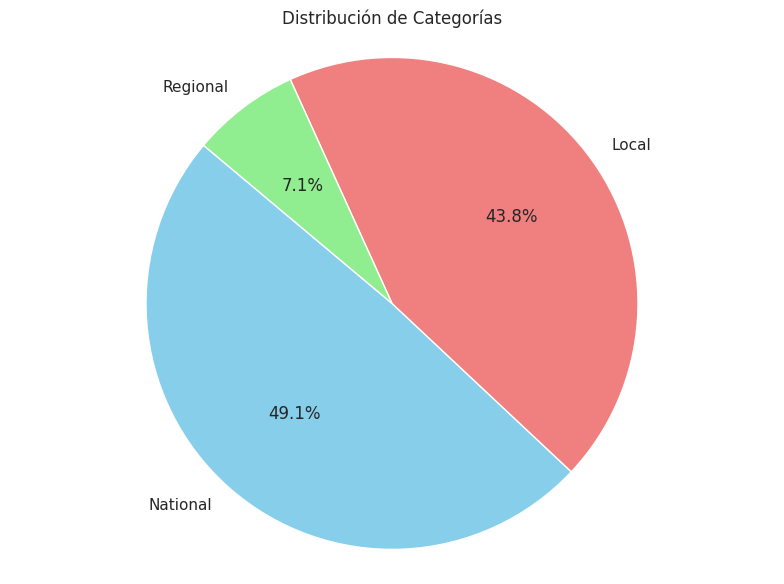

In [ ]:
categoria_counts = holidays_events['locale'].value_counts()
porcentaje_repeticion = (categoria_counts / len(holidays_events)) * 100
categorias = porcentaje_repeticion.index
porcentajes = porcentaje_repeticion.values

plt.figure(figsize=(8, 6))
plt.pie(porcentajes, labels=categorias, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Distribución de Categorías')

plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
holidays_events = holidays_events.groupby(holidays_events.index).first()
holidays_events = holidays_events[(holidays_events.locale == 'National') | (holidays_events.locale == 'Local')]

# Creación del modelo


Para aprovechar al máximo la información histórica del conjunto de datos, creamos un DataFrame denominado "calendar" que utiliza el rango de fechas del conjunto de datos como su índice.

Luego, llevamos a cabo el cálculo del promedio semanal de los precios del petróleo con el objetivo de suavizar las fluctuaciones diarias que suelen presentarse en los precios del petróleo. Esto es especialmente importante ya que los precios del petróleo pueden ser altamente volátiles a corto plazo debido a diversos factores.

Posteriormente, incorporamos estos promedios semanales al DataFrame "calendar". Esto se basa en los resultados de análisis previos que indicaron que los precios del petróleo son una variable relevante que debe ser considerada en el contexto de este modelo.

In [ ]:
calendar = pd.DataFrame(index=pd.date_range('2013-01-01', '2017-08-31'))
calendar.index = calendar.index.to_period('D')
oil["dcoilwtico"] = oil["dcoilwtico"].fillna(method='bfill', axis=0)
oil['Average_oil'] = oil['dcoilwtico'].rolling(7).mean()
oil['date'] = pd.to_datetime(oil['date']).dt.to_period('D')
oil.set_index('date', inplace=True)
calendar = calendar.join(oil[['Average_oil']], how='left')
calendar['Average_oil'].fillna(method = 'bfill', inplace = True)

Hemos incorporado otra variable importante para nuestra consideración: los días festivos. Para garantizar que en nuestro DataFrame únicamente figuren los días festivos junto con sus respectivas festividades, hemos fusionado esta información utilizando la columna de fechas ("date").

Además, hemos introducido la columna "dayofweek" para indicar el día de la semana correspondiente a cada fecha, abarcando desde el lunes hasta el domingo. Esto nos permitirá enriquecer nuestro modelo con información sobre si una fecha corresponde a un fin de semana o a un día laboral, lo que aumentará la precisión en la identificación del tipo de festividad.

Finalmente, hemos aplicado la técnica de "One-hot encoding" a todas nuestras variables categóricas, convirtiéndolas en representaciones binarias. Esta transformación es fundamental para que el modelo pueda trabajar eficazmente con estas variables categóricas y es ampliamente conocida como "One-hot encoding".

In [ ]:
holidays_events = holidays_events.reset_index()
holidays_events['date'] = pd.to_datetime(holidays_events['date']).dt.to_period('D')
holidays_events = holidays_events.set_index('date').sort_index()

In [ ]:
calendar = calendar.join(holidays_events[['type']], how='left')
calendar = calendar.join(holidays_events[['locale']], how='left')
calendar = calendar.join(holidays_events[['locale_name']], how='left')
calendar = calendar.join(holidays_events[['description']], how='left')
calendar = calendar.join(holidays_events[['transferred']], how='left')
calendar['dayofweek'] = calendar.index.to_series().dt.dayofweek


In [ ]:
calendar['week_day'] = 1
calendar.loc[calendar.dayofweek > 4, 'week_day'] = 0

calendar.loc[calendar.type == 'Bridge'  , 'week_day'] = 0
calendar.loc[calendar.type == 'Work Day', 'week_day'] = 1
calendar.loc[calendar.type == 'Transfer', 'week_day'] = 0
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == False), 'week_day'] = 0
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == True ), 'week_day'] = 1

calendar = pd.get_dummies(calendar, columns = ['dayofweek'], drop_first = True)
calendar = pd.get_dummies(calendar, columns = ['type'])
calendar.drop(['locale', 'locale_name', 'description', 'transferred'], axis = 1, inplace = True)

In [ ]:
calendar.head(10)

,Average_oil,week_day,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day
2013-01-01,93.122857,0,1,0,0,0,0,0,0,0,0,1,0,0
2013-01-02,93.122857,1,0,1,0,0,0,0,0,0,0,0,0,0
2013-01-03,93.122857,1,0,0,1,0,0,0,0,0,0,0,0,0
2013-01-04,93.122857,1,0,0,0,1,0,0,0,0,0,0,0,0
2013-01-05,93.122857,1,0,0,0,0,1,0,0,0,0,0,0,1
2013-01-06,93.122857,0,0,0,0,0,0,1,0,0,0,0,0,0
2013-01-07,93.122857,1,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-08,93.122857,1,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-09,93.122857,1,0,1,0,0,0,0,0,0,0,0,0,0
2013-01-10,93.218571,1,0,0,1,0,0,0,0,0,0,0,0,0



En esta sección, establecemos los índices para la variable independiente con el objetivo de simplificar la extracción de los datos que serán predichos por nuestro modelo. Además, este proceso se lleva a cabo para evitar posibles conflictos con la biblioteca Scikit-learn.

Posteriormente, desagregamos niveles del índice con el fin de obtener una vista específica de los datos comprendidos entre dos fechas determinadas. En este caso, nos enfocamos en las fechas del año 2017 que preceden al rango de fechas que estamos interesados en predecir.




In [ ]:
train['date'] = train.date.dt.to_period('D')
train = train.set_index(['date', 'store_nbr', 'family']).sort_index()
y = train.unstack(['store_nbr', 'family']).loc['2017-04-30' :'2017-08-15']
y.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 108 entries, 2017-04-30 to 2017-08-15
Freq: D
Columns: 3564 entries, ('sales', '1', 'AUTOMOTIVE') to ('onpromotion', '9', 'SEAFOOD')
dtypes: float32(1782), uint32(1782)
memory usage: 1.5 MB


Los componentes de Fourier son útiles para detectar patrones estacionales, como las fluctuaciones regulares que se producen durante el año o en cualquier otro intervalo de tiempo. Esto resulta valioso al analizar datos estacionales, como el aumento en las ventas minoristas durante las temporadas festivas.

Además, empleamos un "proceso determinístico," que se refiere a un enfoque que busca explícitamente modelar las partes predecibles y deterministas de una serie temporal, en contraposición a las partes aleatorias o estocásticas.

In [ ]:
fourier = CalendarFourier(freq = 'W', order = 3)

dp = DeterministicProcess(index = y.index,
                          order = 1,
                          seasonal = False,
                          constant = False,
                          additional_terms = [fourier],
                          drop = True)
x = dp.in_sample()
x = x.join(calendar)
x

,trend,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)",Average_oil,week_day,dayofweek_1,...,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day
date,,,,,,,,,,,,,,,,,,,,,
2017-04-30,1.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,49.154286,0,0,...,0,0,0,1,0,0,0,0,0,0
2017-05-01,2.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,49.154286,0,0,...,0,0,0,0,0,0,0,1,0,0
2017-05-02,3.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,48.870000,1,1,...,0,0,0,0,0,0,0,0,0,0
2017-05-03,4.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,48.711429,1,0,...,0,0,0,0,0,0,0,0,0,0
2017-05-04,5.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,48.187143,1,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,104.0,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521,49.140000,0,0,...,0,1,0,0,0,0,0,0,1,0
2017-08-12,105.0,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490,48.934286,0,0,...,0,0,1,0,0,0,0,0,0,0
2017-08-13,106.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,48.934286,0,0,...,0,0,0,1,0,0,0,0,0,0


#Entrenamiento

Creamos características determinísticas para los próximos 16 pasos en la serie temporal, que corresponden a las fechas que deseamos pronosticar, específicamente las últimas semanas de agosto de 2017. Estas características se basan en el modelo determinístico previamente definido como "dp."

Posteriormente, combinamos estas características con el DataFrame "calendar" para utilizarlas en la predicción de los valores futuros en la serie temporal.

In [ ]:
x_test = dp.out_of_sample(steps = 16)

x_test = x_test.join(calendar)
x_test.head()


,trend,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)",Average_oil,week_day,dayofweek_1,...,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day
2017-08-16,109.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,48.281429,1,0,...,0,0,0,0,0,0,0,0,0,0
2017-08-17,110.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,47.995714,1,0,...,1,0,0,0,0,0,0,0,0,0
2017-08-18,111.0,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521,47.852857,1,0,...,0,1,0,0,0,0,0,0,0,0
2017-08-19,112.0,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490,47.688571,0,0,...,0,0,1,0,0,0,0,0,0,0
2017-08-20,113.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,47.688571,0,0,...,0,0,0,1,0,0,0,0,0,0


Realizamos la regresión lineal con las variables necesarias para su correcxta ejecución.

In [ ]:
linear_model = LinearRegression()
linear_model.fit(x, y)

LinearRegression()

Por último,

In [ ]:
yfit_linear = pd.DataFrame(linear_model.predict(x), index = x.index, columns = y.columns).clip(0.)
ypred_linear = pd.DataFrame(linear_model.predict(x_test), index = x_test.index, columns = y.columns).clip(0.)

print('Linear RMSE :', np.sqrt(mean_squared_log_error (y, yfit_linear)))
print('Linear MAE :', mean_absolute_error(y, yfit_linear))
print('Linear MSE:', mean_squared_error(y, yfit_linear))

Linear RMSE : 0.412414067966201
Linear MAE : 30.360991132395284
Linear MSE: 26551.151702872827


In [ ]:
yfit_linear

sales                                                          \
store_nbr           1                                                           
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2017-04-30   1.695932       0.0  1.331411  1097.643521  0.456177   179.318542   
2017-05-01   1.548658       0.0  3.164038  1901.249050  0.417996   336.980278   
2017-05-02   3.450424       0.0  2.694451  2476.464471  0.656110   390.060889   
2017-05-03   3.494487       0.0  3.837159  2482.525055  0.764737   429.293296   
2017-05-04   3.323096       0.0  3.194781  2151.912327  0.568194   380.847299   
...               ...       ...       ...          ...       ...          ...   
2017-08-11   1.566198       0.0  0.788686  1024.637288  0.000000   152.661428   
2017-08-12   6.345483       0.0  3.588646  2339.995041  0.000000   336.331865   
2017-08-13   3.329013       0.0  1.906262  1004.591033  0.000000   132.486289   
2017-08-14   5.100959       0.0  3.647297  2248.854364  0.149947   346.661186   
2017-08-15   3.164169       0.0  3.361168  1942.774594  0.000000   286.721373   

                                                            ... onpromotion  \
store_nbr                                                   ...           9   
family     CELEBRATION    CLEANING       DAIRY        DELI  ...   MAGAZINES   
date                                                        ...               
2017-04-30    4.116194  272.973982  383.179074   69.785266  ...         0.0   
2017-05-01   16.083440  589.127149  685.443972  123.637704  ...         0.0   
2017-05-02   16.553511  814.078238  772.730444  139.082139  ...         0.0   
2017-05-03   15.866865  880.836291  886.230286  148.358541  ...         0.0   
2017-05-04   20.117137  727.642602  760.375023  124.285532  ...         0.0   
...                ...         ...         ...         ...  ...         ...   
2017-08-11    4.590355  296.492658  320.403414   71.636070  ...         0.0   
2017-08-12    8.387375  566.993173  679.843031  132.403667  ...         0.0   
2017-08-13    0.739224  193.738106  269.479257   64.061885  ...         0.0   
2017-08-14   11.299275  611.294918  669.638699  137.906513  ...         0.0   
2017-08-15   14.584901  633.451291  561.147050  113.367401  ...         0.0   

                                                                          \
store_nbr                                                                  
family          MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                       
2017-04-30   0.791991     18.634200          0.0                0.132788   
2017-05-01   0.431541     20.521156          0.0                0.000000   
2017-05-02   0.976343     17.804869          0.0                0.061579   
2017-05-03   0.556497     17.576370          0.0                0.129604   
2017-05-04  20.256633     16.741105          0.0                0.000000   
...               ...           ...          ...                     ...   
2017-08-11   0.000000      6.790643          0.0                0.000000   
2017-08-12   0.263646      7.157976          0.0                0.000000   
2017-08-13   0.224359      7.392254          0.0                0.125004   
2017-08-14   0.090589      6.179458          0.0                0.000000   
2017-08-15   0.182132      9.662365          0.0                0.035283   

                                                                             \
store_nbr                                                                     
family        POULTRY PREPARED FOODS     PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                          
2017-04-30   0.000000       0.000000    1.437146                   0.000000   
2017-05-01   0.045227       0.069737    0.999169                   0.869160   

In [ ]:
Cross_val = abs(cross_val_score(LinearRegression(), x, y, cv=5, scoring = "neg_root_mean_squared_error").mean())
print ("Cross validation RMSE: ", Cross_val)
Cross_val2 = abs(cross_val_score(LinearRegression(), x, y, cv=5, scoring = "neg_mean_absolute_error").mean())
print ("Cross validation MAE: ", Cross_val2)
Cross_val3 = abs(cross_val_score(LinearRegression(), x, y, cv=5, scoring = "neg_mean_squared_error").mean())
print ("Cross validation MSE: ", Cross_val3)


Cross validation RMSE:  51.28557109403382
Cross validation MAE:  38.610445636872775
Cross validation MSE:  40635.5063656727


* Fase de Prueba (Test):

Bias/Sesgo: En la fase de prueba, observamos un RMSE (Root Mean Square Error) de 0.4124 y un MAE (Mean Absolute Error) de 30.361. Estos valores bajos indican que el modelo tiene un bajo sesgo en esta fase, ya que las predicciones se ajustan bastante bien a los valores reales. El bajo sesgo sugiere que el modelo está capturando adecuadamente la tendencia subyacente en los datos de prueba.

Nivel de Ajuste (Fit): Los valores bajos de RMSE y MAE en la fase de prueba también sugieren que el modelo tiene un buen nivel de ajuste a los datos de prueba, ya que los errores de predicción son relativamente pequeños. El modelo se adapta bien a estos datos específicos.

Varianza: En la fase de prueba, el MSE (Error Cuadrático Medio) es de 26551.15, lo que indica que el modelo tiene una varianza moderada en sus predicciones. Un valor moderado de MSE sugiere que el modelo no es demasiado sensible a variaciones extremas en los datos de prueba.

Validación Cruzada (Cross Validation):

Bias/Sesgo: En la validación cruzada, observamos un RMSE de 51.2856 y un MAE de 38.6104. Estos valores son más altos que los de la fase de prueba, lo que sugiere un sesgo ligeramente mayor en la validación cruzada en comparación con la fase de prueba. El sesgo más alto puede indicar que el modelo tiene dificultades para generalizar completamente a nuevos datos, como los utilizados en la validación cruzada.

Nivel de Ajuste (Fit): Aunque los valores de RMSE y MAE en la validación cruzada son más altos que en la fase de prueba, aún son relativamente moderados. Esto sugiere que el modelo tiene un nivel de ajuste razonable en la validación cruzada, aunque no es tan bueno como en la fase de prueba.

Varianza: En la validación cruzada, el MSE es de 40635.51, lo que indica una varianza moderada en las predicciones. Similar a la fase de prueba, el modelo no es excesivamente sensible a variaciones extremas en los datos utilizados en la validación cruzada.

En resumen, el modelo parece tener un sesgo razonablemente bajo y un nivel de ajuste adecuado en la fase de prueba, lo que sugiere que se adapta bien a los datos de prueba específicos. Sin embargo, en la validación cruzada, aunque los resultados son aún razonables, hay indicios de un sesgo ligeramente mayor y un nivel de ajuste ligeramente inferior, lo que podría indicar que el modelo tiene dificultades para generalizar por completo a nuevos datos. La varianza en ambas fases es moderada, lo que sugiere que el modelo no es extremadamente sensible a variaciones en los datos.

In [ ]:
y_submit = ypred_linear.stack(["store_nbr","family"])
y_submit

onpromotion        sales
           store_nbr family                                              
2017-08-16 1         AUTOMOTIVE                     0.000000     5.110577
                     BABY CARE                      0.000000     0.000000
                     BEAUTY                         0.688124     4.452616
                     BEVERAGES                     23.090604  2392.472959
                     BOOKS                          0.000000     0.246424
...                                                      ...          ...
2017-08-31 9         POULTRY                        0.420670   308.787164
                     PREPARED FOODS                 0.832523    86.058615
                     PRODUCE                       12.374879  1132.184621
                     SCHOOL AND OFFICE SUPPLIES     6.083512   103.494246
                     SEAFOOD                        0.339905    11.053081

[28512 rows x 2 columns]

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
y_submit = y_submit.droplevel(level=None)

test = test.join(y_submit[['sales']], how='left')

In [ ]:
test = test[["id", "sales"]]

In [ ]:
test.to_csv('submission.csv', index=False)

In [ ]:
x_test

,trend,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)",Average_oil,week_day,dayofweek_1,...,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day
2017-08-16,109.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,48.281429,1,0,...,0,0,0,0,0,0,0,0,0,0
2017-08-17,110.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,47.995714,1,0,...,1,0,0,0,0,0,0,0,0,0
2017-08-18,111.0,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521,47.852857,1,0,...,0,1,0,0,0,0,0,0,0,0
2017-08-19,112.0,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490,47.688571,0,0,...,0,0,1,0,0,0,0,0,0,0
2017-08-20,113.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,47.688571,0,0,...,0,0,0,1,0,0,0,0,0,0
2017-08-21,114.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,47.688571,1,0,...,0,0,0,0,0,0,0,0,0,0
2017-08-22,115.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,47.522857,1,1,...,0,0,0,0,0,0,0,0,0,0
2017-08-23,116.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,47.645714,1,0,...,0,0,0,0,0,0,0,0,0,0
2017-08-24,117.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,47.598571,0,0,...,1,0,0,0,0,0,0,1,0,0
2017-08-25,118.0,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521,47.720000,1,0,...,0,1,0,0,0,0,0,0,0,0


## Guardando el modelo

Estos comandos salva el modelo entrenado como 'linear_model.pkl' en el directorio donde se encuentre el archivo.

In [ ]:
#import joblib
#joblib.dump(linear_model, 'linear_model.pkl')

['linear_model.pkl']